In [1]:
import pandas as pd
import os, sys
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.prediction_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

random_seed = 42

In [2]:
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/experiments/data"
X, y = get_data("sdpa", base_dir, sample_rate=1.0)
X.info()

24it [00:32,  1.35s/it]
100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464256 entries, 0 to 464255
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   b                  464256 non-null  int64  
 1   h                  464256 non-null  int64  
 2   s_q                464256 non-null  int64  
 3   s_kv               464256 non-null  int64  
 4   d_qk               464256 non-null  int64  
 5   d_v                464256 non-null  int64  
 6   gflops             464256 non-null  float64
 7   dtype_16           464256 non-null  bool   
 8   dtype_32           464256 non-null  bool   
 9   dtype_b16          464256 non-null  bool   
 10  backend_cudnn      464256 non-null  bool   
 11  backend_efficient  464256 non-null  bool   
 12  backend_flash      464256 non-null  bool   
 13  is_causal_0        464256 non-null  bool   
 14  is_causal_1        464256 non-null  bool   
dtypes: bool(8), float64(1), int64(6)
memory usage: 28.3

In [3]:
print((y<0).sum())
y.info()

63504
<class 'pandas.core.series.Series'>
RangeIndex: 464256 entries, 0 to 464255
Series name: time
Non-Null Count   Dtype  
--------------   -----  
464254 non-null  float64
dtypes: float64(1)
memory usage: 3.5 MB


In [4]:
df = pd.concat([X, y], axis=1)
df = df.dropna()
df = df[df["time"] > 0]
X, y = df.drop(columns=["time"]), df["time"]

# Initial fitting

Train--------
Mean Squared Error: 3.3109483711262984
MAPE: 0.011099368989254852
R-squared: 0.9970295465072291


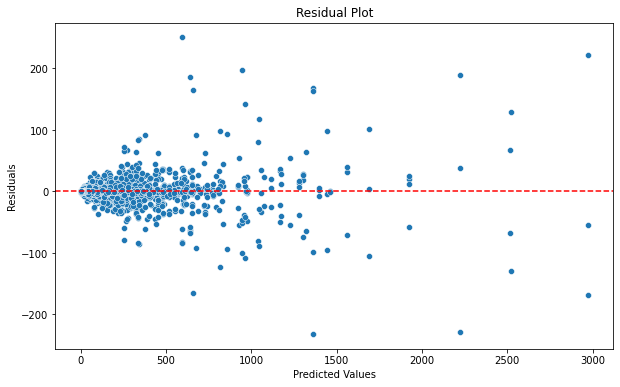

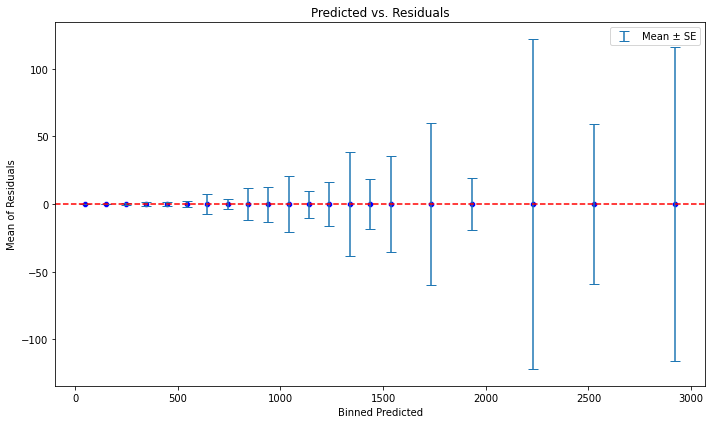

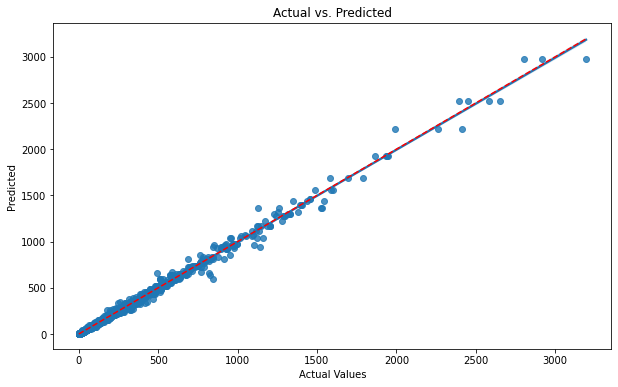

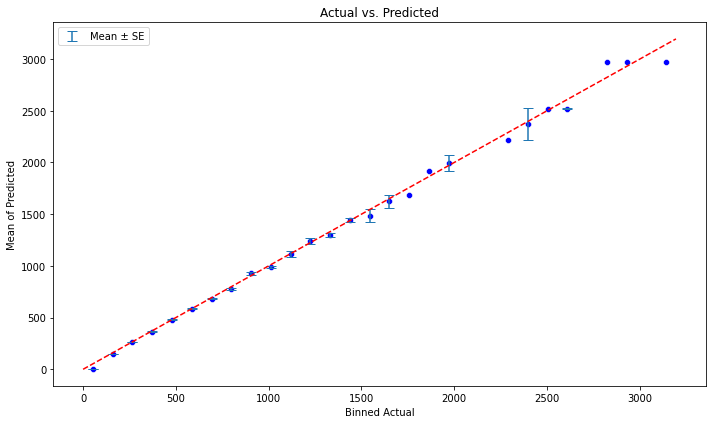

Val--------
Mean Squared Error: 23.96562635401322
MAPE: 0.02523770230283537
R-squared: 0.9770196378472225


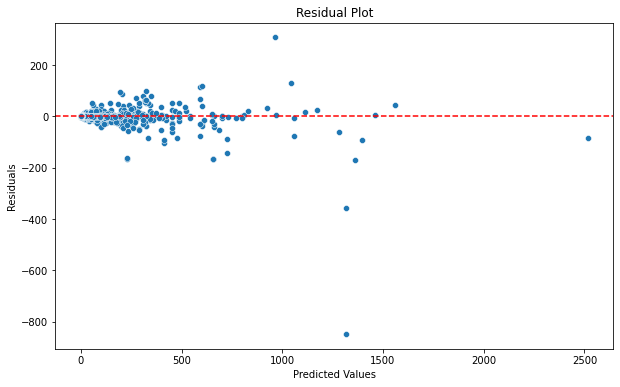

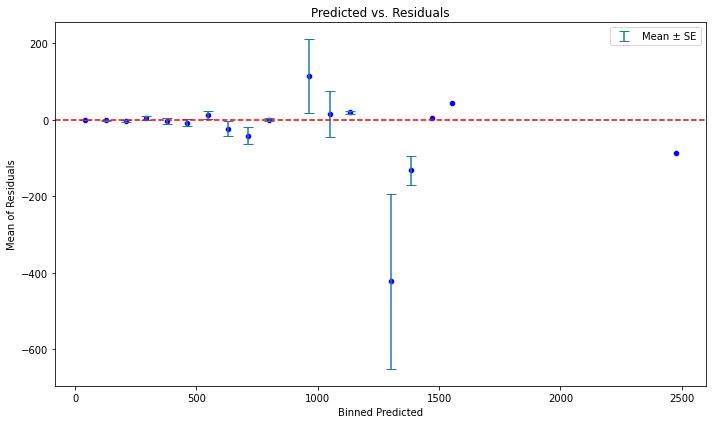

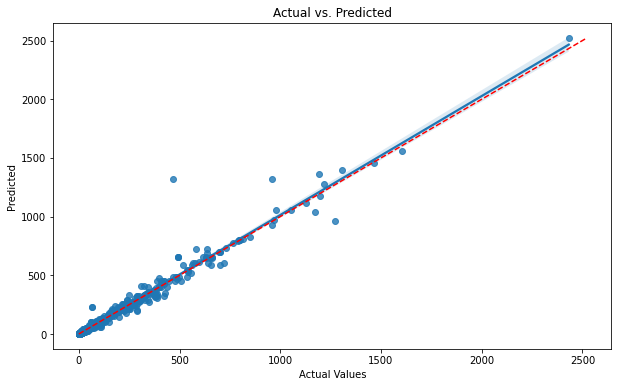

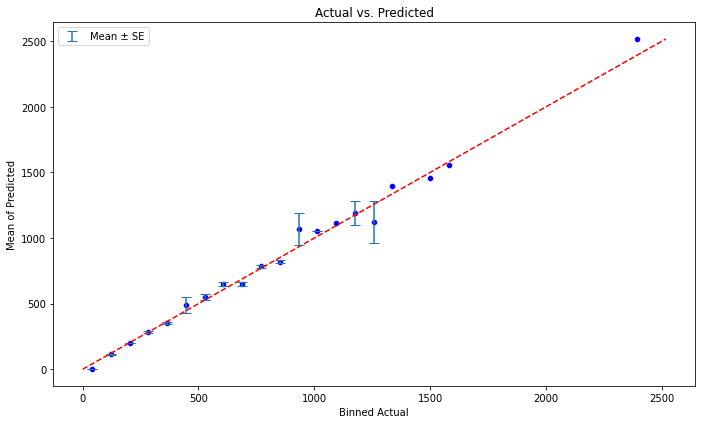

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

tree_model = DecisionTreeRegressor(max_depth=30, min_samples_split=5, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_cv, y_cv)

run_val_pipeline(tree_model, X_cv, X_test, y_cv, y_test, bins=30)

In [10]:
get_feature_importance(X.columns, tree_model)

,Feature,Importance
6,gflops,0.580305
8,dtype_32,0.287267
14,is_causal_1,0.042898
13,is_causal_0,0.042879
2,s_q,0.018698
11,backend_efficient,0.010128
3,s_kv,0.006997
5,d_v,0.005565
4,d_qk,0.003739
1,h,0.000688


# Forest

Train--------
Mean Squared Error: 4.23175388670441
MAPE: 0.012947493466764663
R-squared: 0.9959926274152229


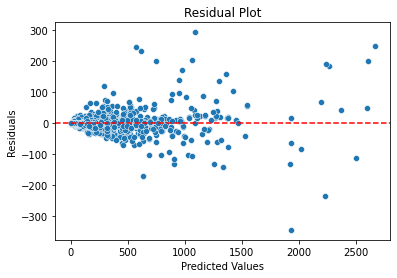

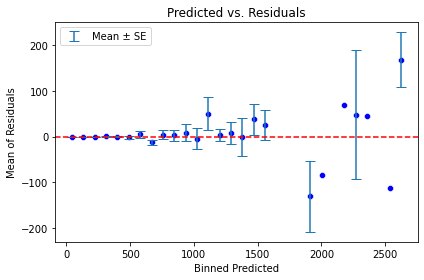

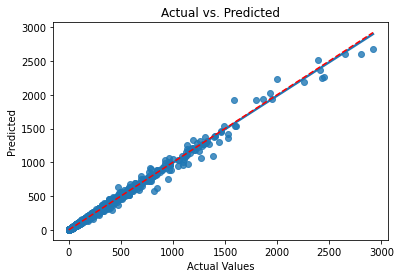

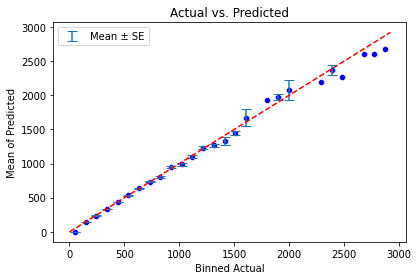

Val--------
Mean Squared Error: 14.39914411785942
MAPE: 0.023445048197671084
R-squared: 0.9895285745693116


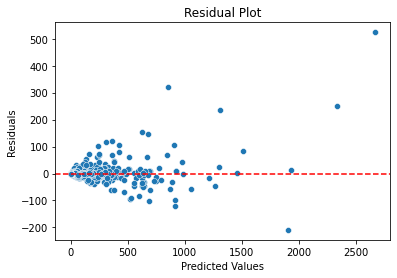

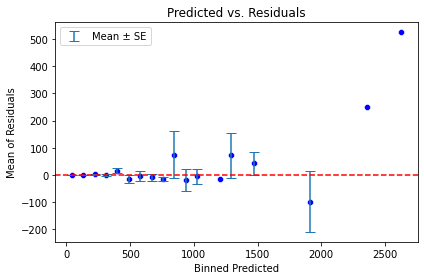

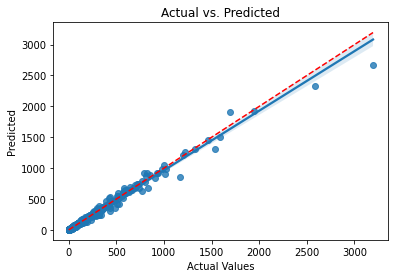

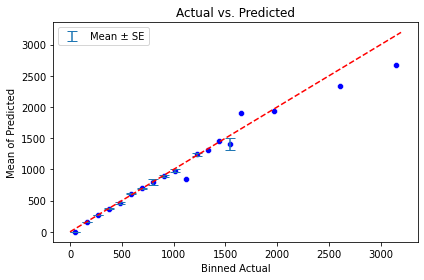

In [13]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

tree_model = RandomForestRegressor(max_depth=80, min_samples_split=2, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_cv, y_cv)

run_val_pipeline(tree_model, X_cv, X_test, y_cv, y_test, bins=30)

In [6]:
get_feature_importance(X.columns, tree_model)

,Feature,Importance
6,gflops,0.583505
8,dtype_32,0.283202
13,is_causal_0,0.043714
14,is_causal_1,0.042570
2,s_q,0.018397
11,backend_efficient,0.009707
3,s_kv,0.007065
5,d_v,0.006299
4,d_qk,0.004062
0,b,0.000600


### By dtype

Train--------
Mean Squared Error: 5.232576843392042
MAPE: 0.014584884022172636
R-squared: 0.9949596354640755


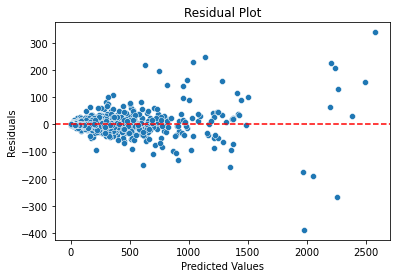

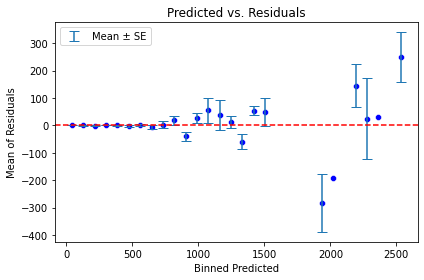

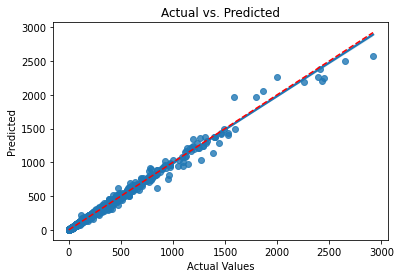

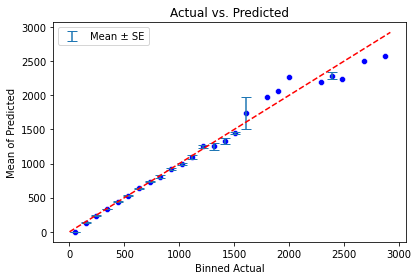

Val--------
Mean Squared Error: 12.205459587526304
MAPE: 0.026544744684807543
R-squared: 0.9892871406656183


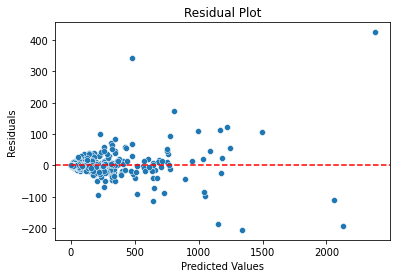

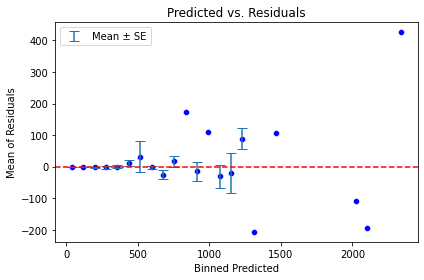

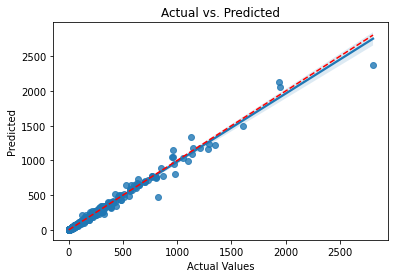

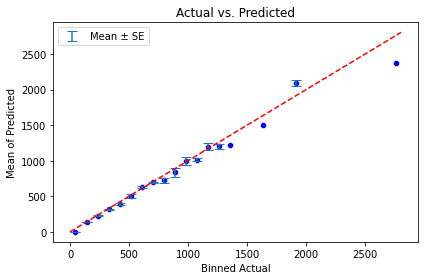

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)

tree_model = RandomForestRegressor(max_depth=80, min_samples_split=2, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_train, y_train)

run_val_pipeline(tree_model, X_train, X_val, y_train, y_val, bins=30)

In [7]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train["time_pred"] = tree_model.predict(X_train)
df_val = pd.concat([X_val, y_val], axis=1)
df_val["time_pred"] = tree_model.predict(X_val)

for dtype in ["16", "32", "b16"]:
    df_train_dtype = df_train.query(f"dtype_{dtype}")
    df_val_dtype = df_val.query(f"dtype_{dtype}")
    
    print(dtype, mean_squared_error(df_train_dtype["time"], df_train_dtype["time_pred"]), mean_squared_error(df_val_dtype["time"], df_val_dtype["time_pred"]))
    print(dtype, mean_absolute_percentage_error(df_train_dtype["time"], df_train_dtype["time_pred"]), mean_absolute_percentage_error(df_val_dtype["time"], df_val_dtype["time_pred"]))

16 0.5080291484984015 1.0610318770923626
16 0.01261927876352092 0.022918959631047342
32 26.745002520705814 62.91807650156915
32 0.023806455101242924 0.04364057662183882
b16 0.46986326447619015 0.9379338546556477
b16 0.012483722643948513 0.022615079272956345


Train--------
Mean Squared Error: 26.745002520705814
MAPE: 0.023806455101242924
R-squared: 0.9944252769898398


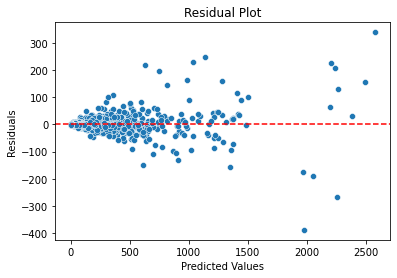

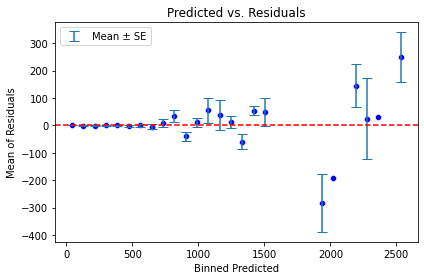

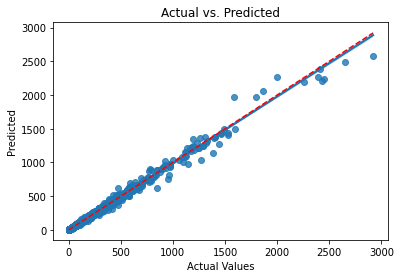

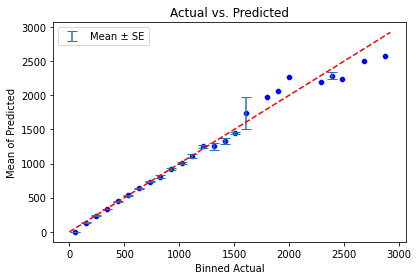

Val--------
Mean Squared Error: 62.91807650156915
MAPE: 0.04364057662183882
R-squared: 0.9885152361322418


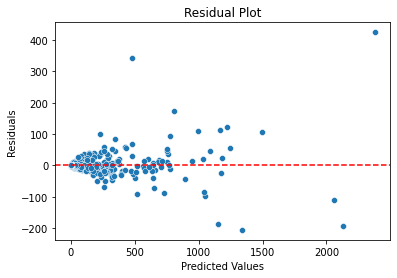

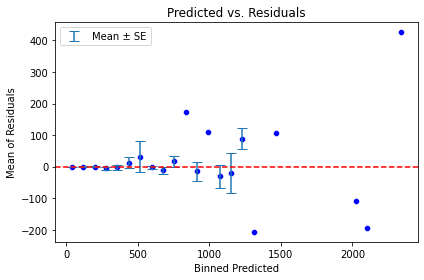

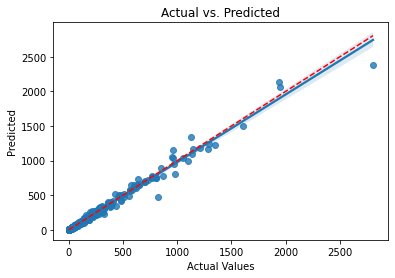

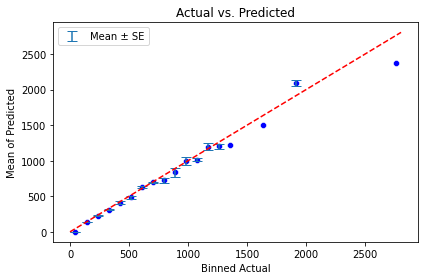

In [11]:
run_val_pipeline(tree_model, df_train.query("dtype_32").drop(columns=["time", "time_pred"]), df_val.query("dtype_32").drop(columns=["time", "time_pred"]), df_train.query("dtype_32")["time"], df_val.query("dtype_32")["time"], bins=30)

# What's up with the incorrectly predicted values?

In [6]:
df.query("time > 2000")

,b,h,s_q,s_kv,d_qk,d_v,gflops,dtype_16,dtype_32,dtype_b16,backend_cudnn,backend_efficient,backend_flash,is_causal_0,is_causal_1,time
436806,128,12,8192,8192,128,256,79164.837200,False,True,False,False,True,False,True,False,2411.081055
437727,128,12,8192,8192,256,256,105553.116266,False,True,False,False,True,False,True,False,2919.393555
441224,128,12,8192,8192,64,256,65970.697667,False,True,False,False,True,False,True,False,2450.255859
442074,128,12,8192,8192,32,256,59373.627900,False,True,False,False,True,False,True,False,2432.187500
446972,128,16,8192,8192,256,64,87960.930222,False,True,False,False,True,False,True,False,2394.688477
448706,128,16,8192,8192,256,128,105553.116266,False,True,False,False,True,False,True,False,2651.693115
454016,128,16,8192,8192,32,256,79164.837200,False,True,False,False,True,False,True,False,2585.988037
455775,128,16,8192,8192,128,256,105553.116266,False,True,False,False,True,False,True,False,3195.153320
457827,128,16,8192,8192,64,256,87960.930222,False,True,False,False,True,False,True,False,2805.092041
462698,128,16,8192,8192,256,32,79164.837200,False,True,False,False,True,False,True,False,2260.743652


# Per dtype and backend

## dtype 32

Most of the MSE seems to come from dtype 32

Train--------
Mean Squared Error: 25.495543758931234
MAPE: 0.018389053176811977
R-squared: 0.9950074418566169


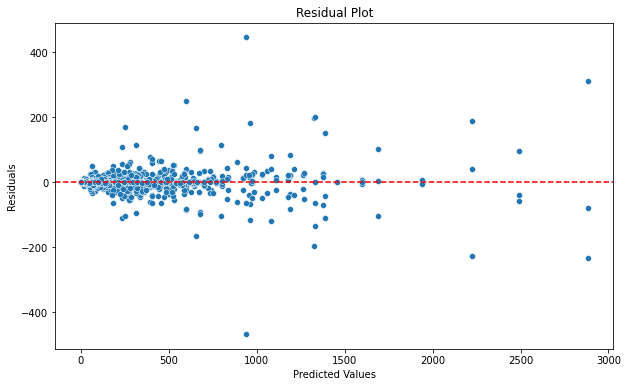

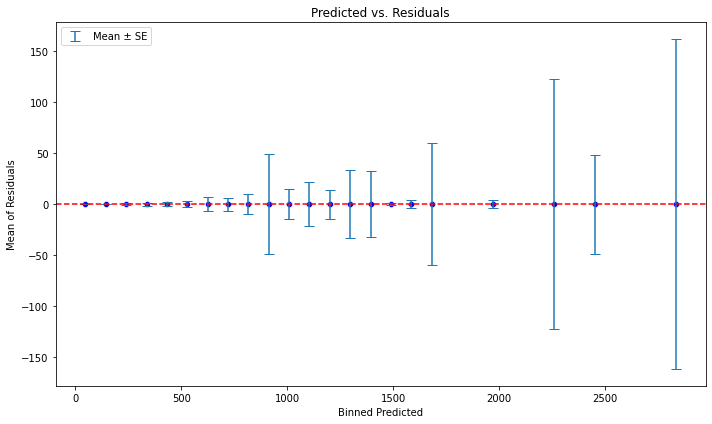

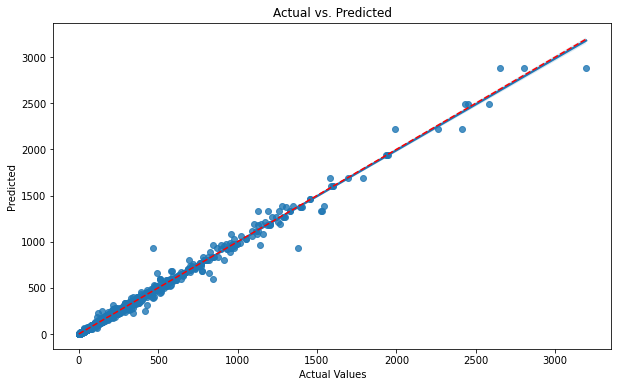

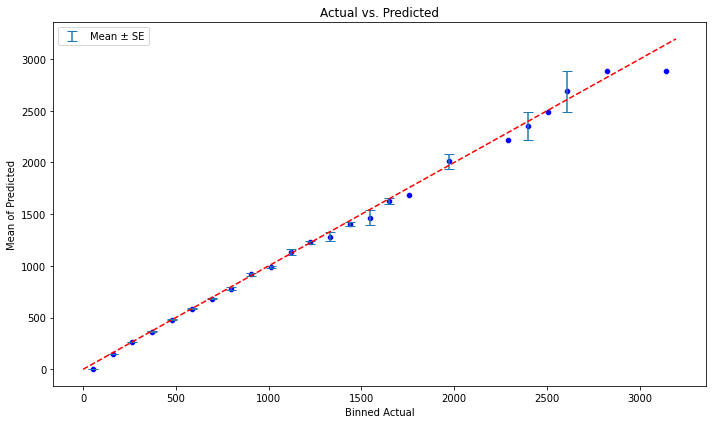

Val--------
Mean Squared Error: 84.81221955529237
MAPE: 0.04372748232816779
R-squared: 0.9847342905641047


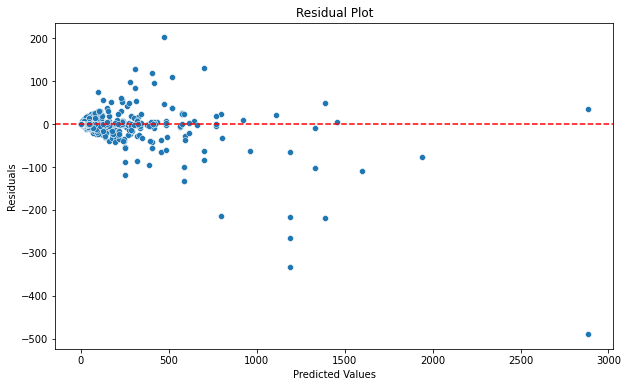

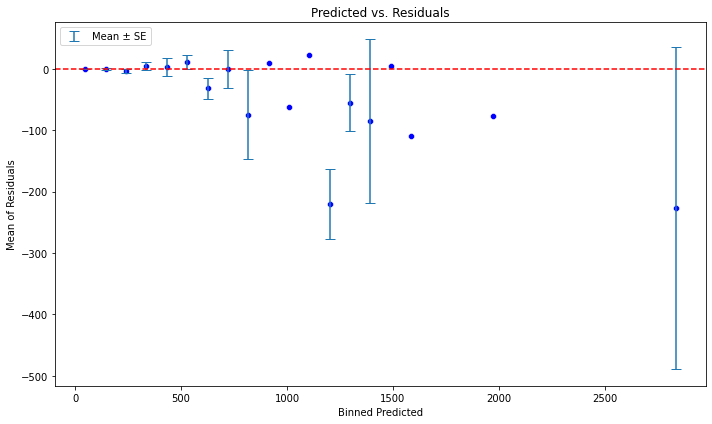

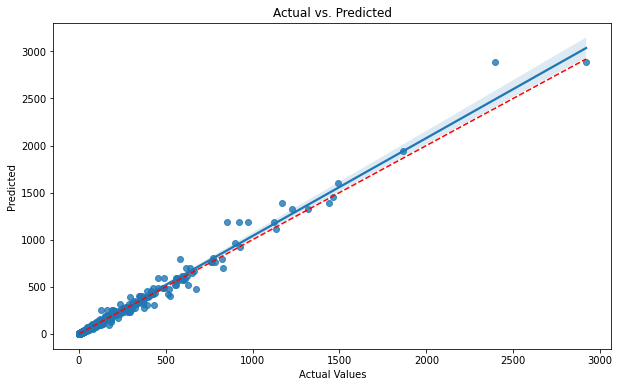

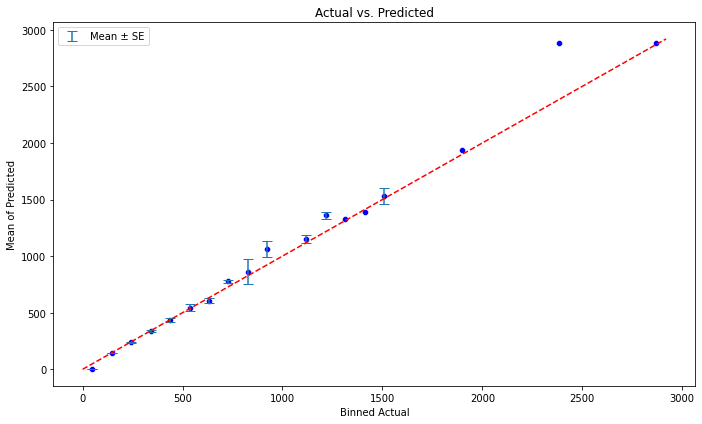

In [9]:
df_dtype = df.query("dtype_32")
X_dtype, y_dtype = df_dtype.drop(columns=["time"]), df_dtype["time"]

X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X_dtype, y_dtype, return_concat=False)
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

tree_model = DecisionTreeRegressor(max_depth=30, min_samples_split=5, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_cv, y_cv)

run_val_pipeline(tree_model, X_cv, X_test, y_cv, y_test, bins=30)

## dtype16

### Combined

Train--------
Mean Squared Error: 0.9650085098705699
MAPE: 0.015514442042632949
R-squared: 0.9948377834111132


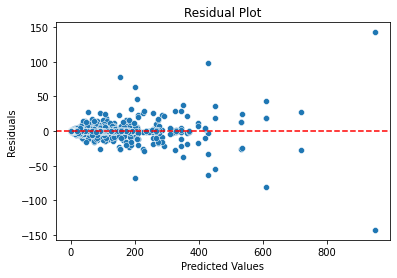

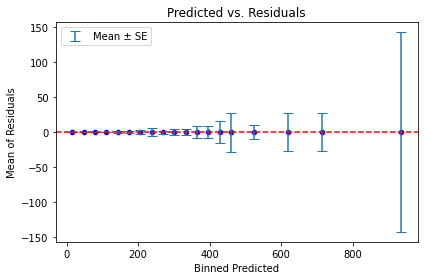

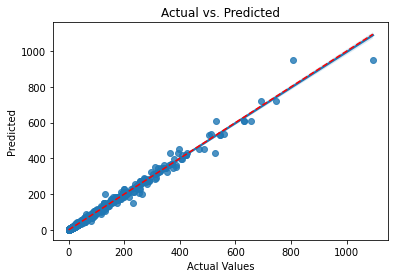

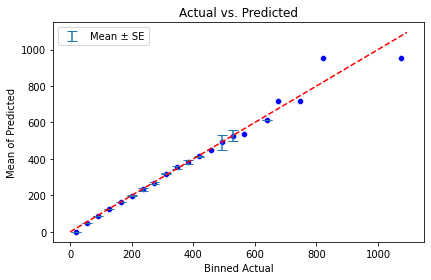

Val--------
Mean Squared Error: 5.607385288831293
MAPE: 0.03734606797049339
R-squared: 0.9716041767302835


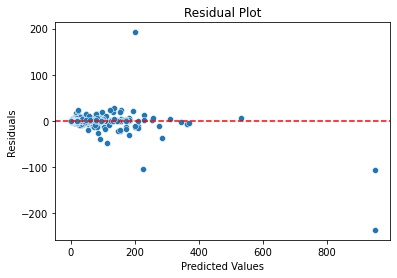

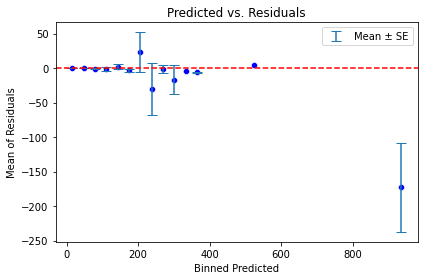

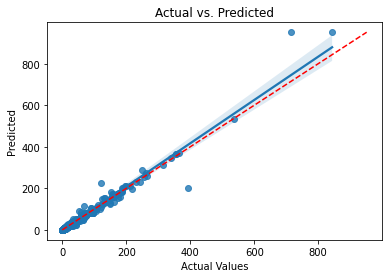

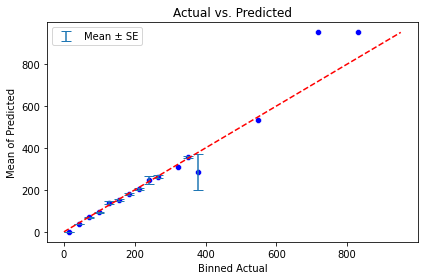

In [7]:
df_dtype = df.query("dtype_16")
X_dtype, y_dtype = df_dtype.drop(columns=["time"]), df_dtype["time"]

X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X_dtype, y_dtype, return_concat=False)
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

tree_model = DecisionTreeRegressor(max_depth=40, min_samples_split=5, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_cv, y_cv)

run_val_pipeline(tree_model, X_cv, X_test, y_cv, y_test, bins=30)

### Cudnn

Train--------
Mean Squared Error: 0.0927233862463872
MAPE: 0.016683035198460646
R-squared: 0.9927247808920769


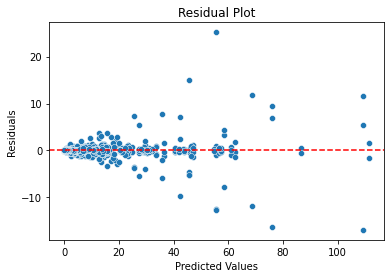

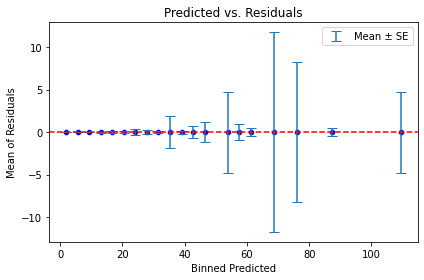

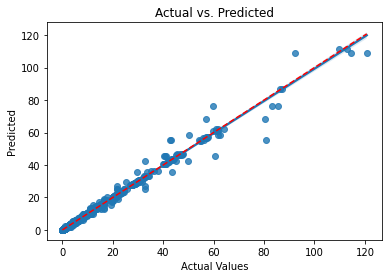

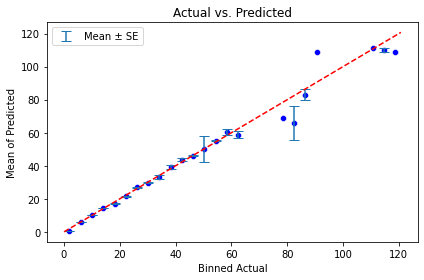

Val--------
Mean Squared Error: 0.41866539484880366
MAPE: 0.04076442427361947
R-squared: 0.9711873812960339


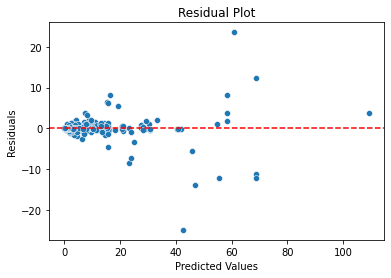

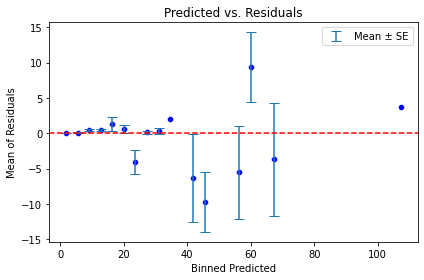

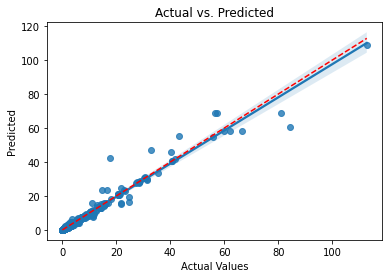

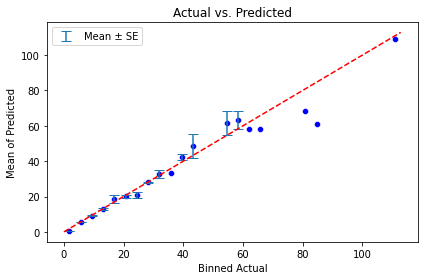

In [8]:
df_dtype = df.query("dtype_16 and backend_cudnn")
X_dtype, y_dtype = df_dtype.drop(columns=["time"]), df_dtype["time"]

X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X_dtype, y_dtype, return_concat=False)
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

tree_model = DecisionTreeRegressor(max_depth=30, min_samples_split=5, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_cv, y_cv)

run_val_pipeline(tree_model, X_cv, X_test, y_cv, y_test, bins=30)

### Flash

Train--------
Mean Squared Error: 0.09001523173229847
MAPE: 0.013245534148417802
R-squared: 0.9975258852241424


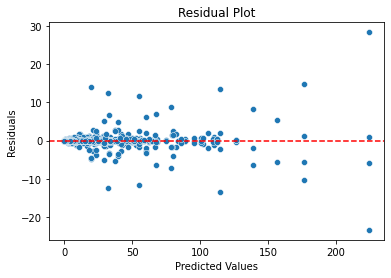

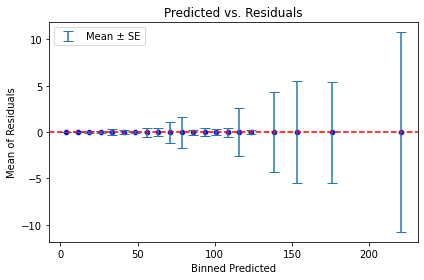

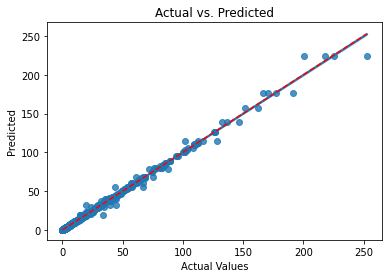

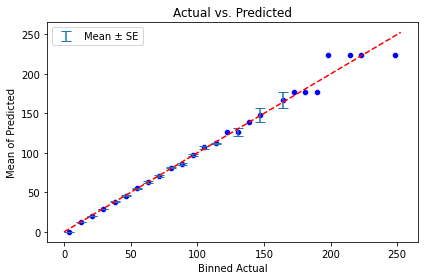

Val--------
Mean Squared Error: 0.48781792260052603
MAPE: 0.030380401221763817
R-squared: 0.9824646555572663


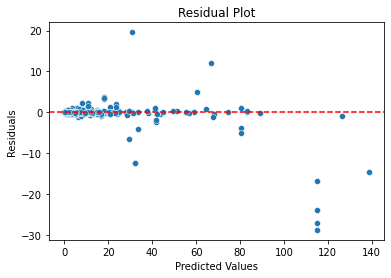

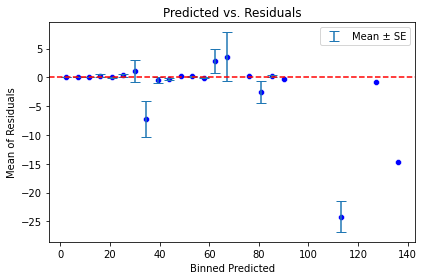

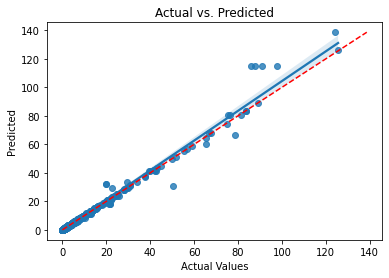

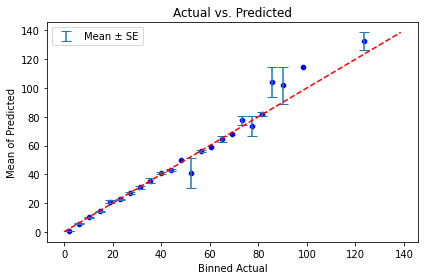

In [9]:
df_dtype = df.query("dtype_16 and backend_flash")
X_dtype, y_dtype = df_dtype.drop(columns=["time"]), df_dtype["time"]

X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X_dtype, y_dtype, return_concat=False)
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

tree_model = DecisionTreeRegressor(max_depth=30, min_samples_split=5, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_cv, y_cv)

run_val_pipeline(tree_model, X_cv, X_test, y_cv, y_test, bins=30)

### Efficient

Train--------
Mean Squared Error: 1.2605003574501323
MAPE: 0.014954293512251644
R-squared: 0.9968153465475719


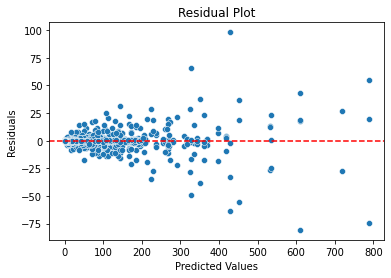

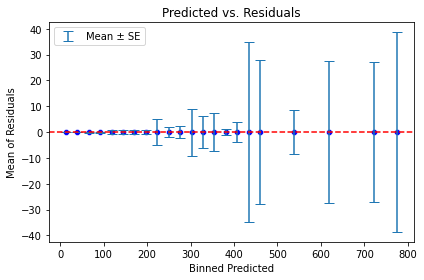

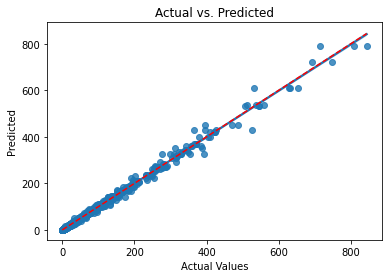

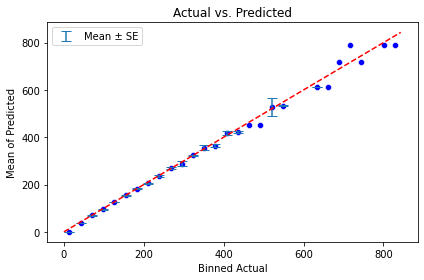

Val--------
Mean Squared Error: 11.135394594969217
MAPE: 0.035946339473242175
R-squared: 0.9693319462764546


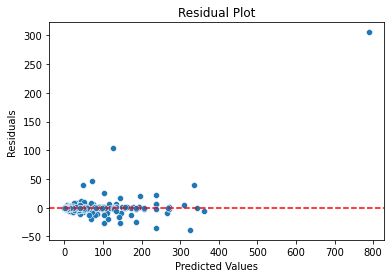

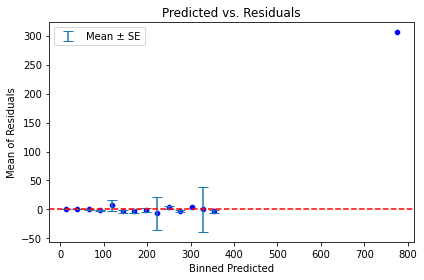

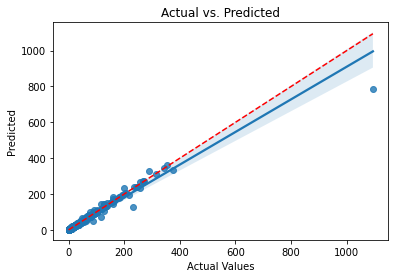

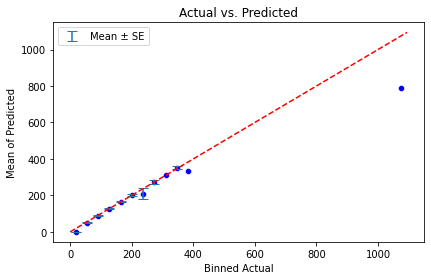

In [10]:
df_dtype = df.query("dtype_16 and backend_efficient")
X_dtype, y_dtype = df_dtype.drop(columns=["time"]), df_dtype["time"]

X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X_dtype, y_dtype, return_concat=False)
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

tree_model = DecisionTreeRegressor(max_depth=30, min_samples_split=5, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_cv, y_cv)

run_val_pipeline(tree_model, X_cv, X_test, y_cv, y_test, bins=30)

## b16

Train--------
Mean Squared Error: 1.1721390403979668
MAPE: 0.015043664782749629
R-squared: 0.9937132788063353


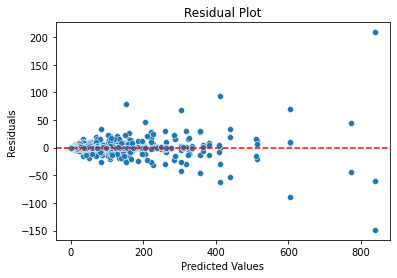

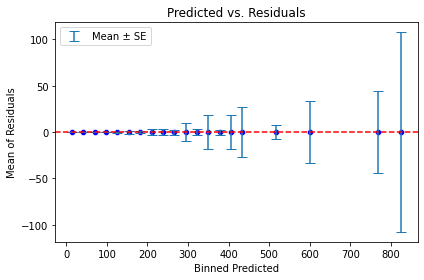

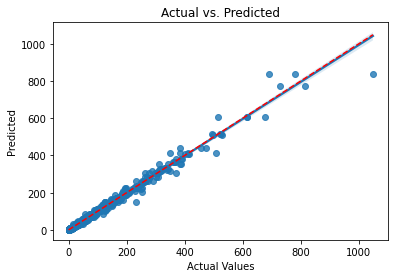

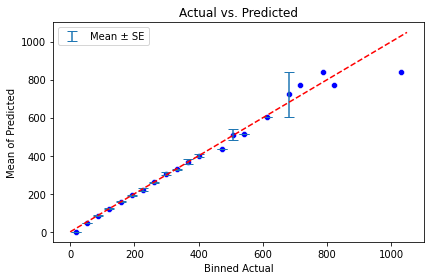

Val--------
Mean Squared Error: 2.9056941408845898
MAPE: 0.03699643228069225
R-squared: 0.9792125152947845


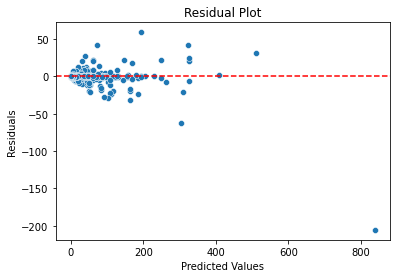

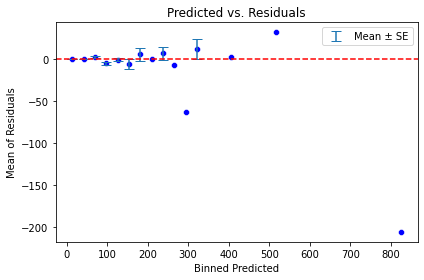

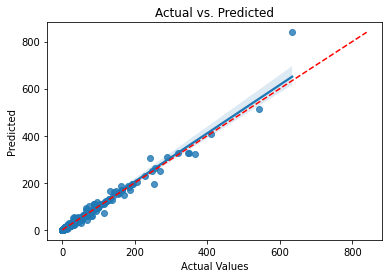

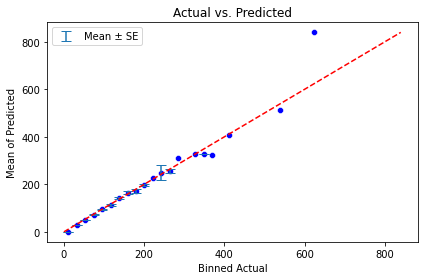

In [11]:
df_32 = df.query("dtype_b16")
X_32, y_32 = df_32.drop(columns=["time"]), df_32["time"]

X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X_32, y_32, return_concat=False)
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

tree_model = DecisionTreeRegressor(max_depth=50, min_samples_split=5, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_cv, y_cv)

run_val_pipeline(tree_model, X_cv, X_test, y_cv, y_test, bins=30)

# Save Model

In [14]:
import joblib
joblib.dump(tree_model, '../h100_models/sdpa.joblib')

['../h100_models/sdpa.joblib']